평가문항	상세기준
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?	

블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.

2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?	

tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.

3. Ablation Study 결과가 바른 포맷으로 제출되었는가?	

ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

# 목차

1) ResNet 기본 블록 구성하기

2) ResNet-34, ResNet-50 Complete Model 구성하기

3) 일반 네트워크(plain network) 만들기

4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34 비교하기



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

# cats_vs_dogs 데이터셋의 URL을 새로운 링크로 설정합니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 데이터셋을 80%는 학습용, 20%는 테스트용으로 분할하여 불러옵니다.
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,   
    shuffle_files=True,
    with_info=True,
)


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
def normalize_and_resize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [224, 224])
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

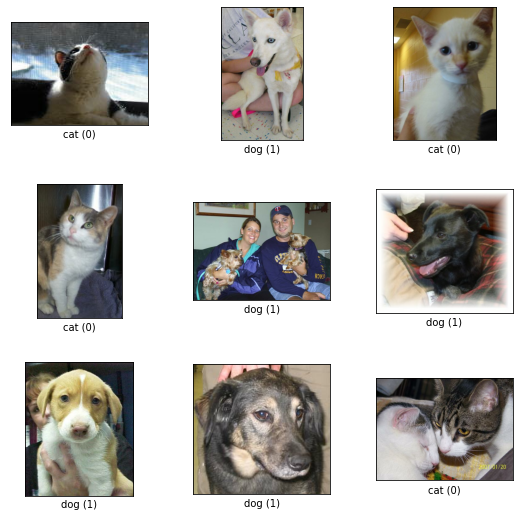

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

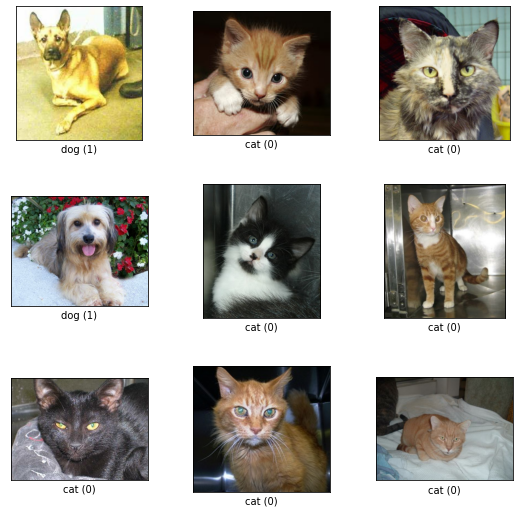

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

# block 코드 변경

resnet 34, 50 만들기 

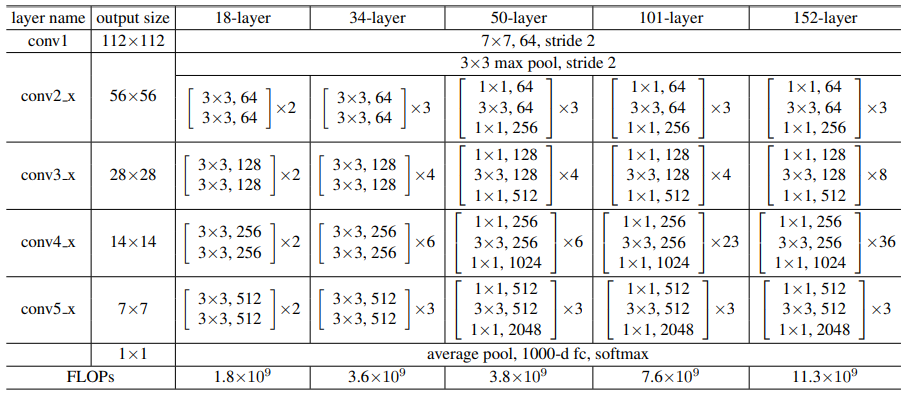



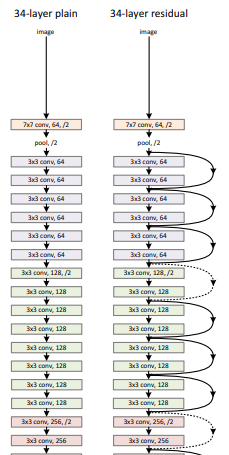

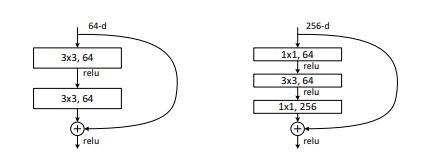

마지막에 relu를 추가해야 하는 것도 기억

We adopt batch
normalization (BN) [16] right after each convolution and
before activation, following [16].

batch normalization도 있음.

위를 참고하여 공통적으로 3,4,6,3 으로 공통되나 1x1가 위아래로 있음을 기억

In [12]:
import tensorflow as tf
from tensorflow import keras

def build_resnet(version='50', input_shape=(224,224,3), num_classes=1000, is_plain=False):
    """
    하나의 함수로 ResNet-50/ResNet-34 또는 PlainNet-50/PlainNet-34를 생성합니다.
    
    Parameters:
      - version: '50' 또는 '34'
          * '50'이면 병목(bottleneck) 블록을 사용 (ResNet-50 구조)
          * '34'이면 기본(basic) 블록을 사용 (ResNet-34 구조)
      - is_plain: False이면 skip connection을 포함한 ResNet, True이면 skip connection을 제거한 PlainNet
      - input_shape: 입력 이미지 크기 (기본값: (224,224,3)) 로 요구했음
    """
    inputs = keras.Input(shape=input_shape)
    
    # 초기 Convolution 및 MaxPooling 
    x = keras.layers.Conv2D(64, (7,7), strides=2, padding='same',
                            kernel_initializer='he_normal', name='conv1')(inputs)
    x = keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = keras.layers.Activation('relu', name='conv1_relu')(x)
    x = keras.layers.MaxPooling2D((3,3), strides=2, padding='same', name='pool1')(x)
    
    # 각 스테이지별 블록 구성 정보
    if version == '50':
        block_counts = [3, 4, 6, 3]
        filter_list = [256, 512, 1024, 2048]
    elif version == '34':
        block_counts = [3, 4, 6, 3]
        filter_list = [64, 128, 256, 512]
    else:
        raise ValueError("version은 '50' 또는 '34'이어야 합니다.")
    
    # 스테이지 별 블록 쌓기
    for stage, (num_blocks, filters) in enumerate(zip(block_counts, filter_list)):
        for block in range(num_blocks):
            stride = 2 if (block == 0 and stage != 0) else 1
            block_name = f'stage{stage+1}_block{block+1}'
            
            if version == '50':  
                #  블록 구현
                bottleneck_filters = filters // 4
                
                # 1x1 Conv
                y = keras.layers.Conv2D(bottleneck_filters, (1,1), strides=1, padding='same',
                                        kernel_initializer='he_normal', name=block_name+'_conv1')(x)
                y = keras.layers.BatchNormalization(name=block_name+'_bn1')(y)
                y = keras.layers.Activation('relu', name=block_name+'_relu1')(y)
                
                # 3x3 Conv (stride 적용)
                y = keras.layers.Conv2D(bottleneck_filters, (3,3), strides=stride, padding='same',
                                        kernel_initializer='he_normal', name=block_name+'_conv2')(y)
                y = keras.layers.BatchNormalization(name=block_name+'_bn2')(y)
                y = keras.layers.Activation('relu', name=block_name+'_relu2')(y)
                
                # 1x1 Conv
                y = keras.layers.Conv2D(filters, (1,1), strides=1, padding='same',
                                        kernel_initializer='he_normal', name=block_name+'_conv3')(y)
                y = keras.layers.BatchNormalization(name=block_name+'_bn3')(y)
                
                if not is_plain:
                    # shortcut 경로: 입력의 크기가 다르면 1x1 Conv 적용
                    shortcut = x
                    if stride != 1 or x.shape[-1] != filters:
                        shortcut = keras.layers.Conv2D(filters, (1,1), strides=stride, padding='same',
                                                       kernel_initializer='he_normal', name=block_name+'_shortcut_conv')(x)
                        shortcut = keras.layers.BatchNormalization(name=block_name+'_shortcut_bn')(shortcut)
                    y = keras.layers.Add(name=block_name+'_add')([y, shortcut])
                y = keras.layers.Activation('relu', name=block_name+'_relu3')(y)
                x = y
            else:  
                # 기본(basic) 블록 구현 (ResNet-34)
                # 첫 번째 3x3 Conv (stride 적용)
                y = keras.layers.Conv2D(filters, (3,3), strides=stride, padding='same',
                                        kernel_initializer='he_normal', name=block_name+'_conv1')(x)
                y = keras.layers.BatchNormalization(name=block_name+'_bn1')(y)
                y = keras.layers.Activation('relu', name=block_name+'_relu1')(y)
                
                # 두 번째 3x3 Conv
                y = keras.layers.Conv2D(filters, (3,3), strides=1, padding='same',
                                        kernel_initializer='he_normal', name=block_name+'_conv2')(y)
                y = keras.layers.BatchNormalization(name=block_name+'_bn2')(y)
                
                if not is_plain:
                    shortcut = x
                    if stride != 1 or x.shape[-1] != filters:
                        shortcut = keras.layers.Conv2D(filters, (1,1), strides=stride, padding='same',
                                                       kernel_initializer='he_normal', name=block_name+'_shortcut_conv')(x)
                        shortcut = keras.layers.BatchNormalization(name=block_name+'_shortcut_bn')(shortcut)
                    y = keras.layers.Add(name=block_name+'_add')([y, shortcut])
                y = keras.layers.Activation('relu', name=block_name+'_relu2')(y)
                x = y
    
    # 글로벌 평균 풀링 및 출력층
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax', name='fc')(x)
    
    model = keras.Model(inputs, outputs)
    return model

# ResNet-50 (skip connection 포함)
model_resnet50 = build_resnet(version='50', input_shape=(224,224,3), num_classes=1000, is_plain=False)
# ResNet-34 (skip connection 포함)
model_resnet34 = build_resnet(version='34', input_shape=(224,224,3), num_classes=1000, is_plain=False)

# PlainNet-50 (skip connection 제거)
model_plain50 = build_resnet(version='50', input_shape=(224,224,3), num_classes=1000, is_plain=True)
# PlainNet-34 (skip connection 제거)
model_plain34 = build_resnet(version='34', input_shape=(224,224,3), num_classes=1000, is_plain=True)



In [13]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
model_resnet34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
____________________________________________________________________________________________

In [15]:
model_plain50.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 56, 56, 64)        0         
_________________________________________________________________
stage1_block1_conv1 (Conv2D) (None, 56, 56, 64)        4160      
_________________________________________________________________
stage1_block1_bn1 (BatchNorm (None, 56, 56, 64)        256 

In [16]:
model_plain34.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 56, 56, 64)        0         
_________________________________________________________________
stage1_block1_conv1 (Conv2D) (None, 56, 56, 64)        36928     
_________________________________________________________________
stage1_block1_bn1 (BatchNorm (None, 56, 56, 64)        256 

# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [17]:
BATCH_SIZE = 32
EPOCH = 10

In [18]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [19]:
# 전체 예제 수
total_examples = ds_info.splits['train'].num_examples
num_train = int(0.8 * total_examples)
num_val = total_examples - num_train

In [20]:
# 예시: ResNet-50 (skip connection 포함)
model_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_resnet50 = model_resnet50.fit(
    ds_train,
    steps_per_epoch=int(num_train / BATCH_SIZE),
    validation_steps=int(num_val / BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# 예시: ResNet-34 (skip connection 포함)
model_resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_resnet34 = model_resnet34.fit(
    ds_train,
    steps_per_epoch=int(num_train / BATCH_SIZE),
    validation_steps=int(num_val / BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# 예시: PlainNet-50 (skip connection 제거)
model_plain50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_plain50 = model_plain50.fit(
    ds_train,
    steps_per_epoch=int(num_train / BATCH_SIZE),
    validation_steps=int(num_val / BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# 예시: PlainNet-34 (skip connection 제거)
model_plain34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_plain34 = model_plain34.fit(
    ds_train,
    steps_per_epoch=int(num_train / BATCH_SIZE),
    validation_steps=int(num_val / BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)



/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 3:08 - loss: 4.3674 - accuracy: 0.2940

 38/581 [>.............................] - ETA: 3:04 - loss: 3.3607 - accuracy: 0.3668

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:40 - loss: 1.6099 - accuracy: 0.4889

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:31 - loss: 1.0132 - accuracy: 0.5563

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:27 - loss: 1.0033 - accuracy: 0.5561

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:23 - loss: 0.9927 - accuracy: 0.5579

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:13 - loss: 0.9676 - accuracy: 0.5596

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 1:11 - loss: 0.9633 - accuracy: 0.5597

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 1s - loss: 0.8645 - accuracy: 0.5741

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.5739

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 323s 502ms/step - loss: 0.8636 - accuracy: 0.5739 - val_loss: 0.6752 - val_accuracy: 0.6024
Epoch 2/10
 30/581 [>.............................] - ETA: 3:13 - loss: 0.6784 - accuracy: 0.6240

 38/581 [>.............................] - ETA: 3:10 - loss: 0.6793 - accuracy: 0.6151

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 2:46 - loss: 0.6823 - accuracy: 0.6016

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:33 - loss: 0.6725 - accuracy: 0.6072

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:29 - loss: 0.6724 - accuracy: 0.6078

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:25 - loss: 0.6730 - accuracy: 0.6076

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/581 [==================>...........] - ETA: 1:16 - loss: 0.6740 - accuracy: 0.6065

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:14 - loss: 0.6734 - accuracy: 0.6075

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.6146

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 234s 403ms/step - loss: 0.6668 - accuracy: 0.6146 - val_loss: 0.6668 - val_accuracy: 0.6220
Epoch 3/10
  1/581 [..............................] - ETA: 3:29 - loss: 0.7169 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 10/581 [..............................] - ETA: 3:28 - loss: 0.6471 - accuracy: 0.6000

 41/581 [=>............................] - ETA: 3:17 - loss: 0.6599 - accuracy: 0.6128

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:51 - loss: 0.6616 - accuracy: 0.6182

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:35 - loss: 0.6579 - accuracy: 0.6263

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:31 - loss: 0.6588 - accuracy: 0.6251

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:27 - loss: 0.6594 - accuracy: 0.6245

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:17 - loss: 0.6587 - accuracy: 0.6268

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 1:15 - loss: 0.6577 - accuracy: 0.6284

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.6342

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 239s 411ms/step - loss: 0.6528 - accuracy: 0.6342 - val_loss: 0.6711 - val_accuracy: 0.6358
Epoch 4/10
  1/581 [..............................] - ETA: 3:31 - loss: 0.6986 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 3:23 - loss: 0.6307 - accuracy: 0.6532

 41/581 [=>............................] - ETA: 3:19 - loss: 0.6365 - accuracy: 0.6486

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:52 - loss: 0.6450 - accuracy: 0.6363

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:36 - loss: 0.6455 - accuracy: 0.6406

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:31 - loss: 0.6451 - accuracy: 0.6405

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:27 - loss: 0.6455 - accuracy: 0.6399

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:17 - loss: 0.6453 - accuracy: 0.6400

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 1:15 - loss: 0.6442 - accuracy: 0.6412

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.6432

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 239s 412ms/step - loss: 0.6403 - accuracy: 0.6432 - val_loss: 0.6708 - val_accuracy: 0.6405
Epoch 5/10
  1/581 [..............................] - ETA: 3:30 - loss: 0.6012 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 3:22 - loss: 0.6487 - accuracy: 0.6525

 42/581 [=>............................] - ETA: 3:19 - loss: 0.6482 - accuracy: 0.6481

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:52 - loss: 0.6393 - accuracy: 0.6489

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:35 - loss: 0.6355 - accuracy: 0.6475

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:31 - loss: 0.6341 - accuracy: 0.6490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:26 - loss: 0.6328 - accuracy: 0.6498

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:16 - loss: 0.6312 - accuracy: 0.6513

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 1:14 - loss: 0.6312 - accuracy: 0.6514

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.6506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 239s 411ms/step - loss: 0.6306 - accuracy: 0.6506 - val_loss: 0.6333 - val_accuracy: 0.6552
Epoch 6/10
  1/581 [..............................] - ETA: 3:31 - loss: 0.5446 - accuracy: 0.7188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 3:23 - loss: 0.5882 - accuracy: 0.6885

 44/581 [=>............................] - ETA: 3:18 - loss: 0.5975 - accuracy: 0.6776

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:52 - loss: 0.6063 - accuracy: 0.6756

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:35 - loss: 0.6196 - accuracy: 0.6627

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:30 - loss: 0.6191 - accuracy: 0.6626

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:26 - loss: 0.6191 - accuracy: 0.6624

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:16 - loss: 0.6190 - accuracy: 0.6627

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 1:14 - loss: 0.6186 - accuracy: 0.6628

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.6639

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 241s 414ms/step - loss: 0.6189 - accuracy: 0.6639 - val_loss: 0.6979 - val_accuracy: 0.5950
Epoch 7/10
  2/581 [..............................] - ETA: 3:32 - loss: 0.6365 - accuracy: 0.6406

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 3:23 - loss: 0.5896 - accuracy: 0.6744

 44/581 [=>............................] - ETA: 3:18 - loss: 0.5879 - accuracy: 0.6683

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 2:51 - loss: 0.5972 - accuracy: 0.6738

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:34 - loss: 0.6032 - accuracy: 0.6764

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:30 - loss: 0.6041 - accuracy: 0.6757

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:26 - loss: 0.6035 - accuracy: 0.6760

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:16 - loss: 0.6029 - accuracy: 0.6767

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 1:14 - loss: 0.6030 - accuracy: 0.6761

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.6750

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 240s 413ms/step - loss: 0.6040 - accuracy: 0.6750 - val_loss: 0.6868 - val_accuracy: 0.6359
Epoch 8/10
  2/581 [..............................] - ETA: 3:39 - loss: 0.6551 - accuracy: 0.6406

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 3:26 - loss: 0.6152 - accuracy: 0.6598

 46/581 [=>............................] - ETA: 3:22 - loss: 0.6204 - accuracy: 0.6495

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:52 - loss: 0.6047 - accuracy: 0.6727

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:34 - loss: 0.6024 - accuracy: 0.6762

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:29 - loss: 0.6013 - accuracy: 0.6780

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:25 - loss: 0.6002 - accuracy: 0.6794

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 1:15 - loss: 0.5992 - accuracy: 0.6816

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 1:13 - loss: 0.5994 - accuracy: 0.6819

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.6810

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 239s 412ms/step - loss: 0.5999 - accuracy: 0.6810 - val_loss: 0.7188 - val_accuracy: 0.6272
Epoch 9/10
  8/581 [..............................] - ETA: 3:34 - loss: 0.6461 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 25/581 [>.............................] - ETA: 3:29 - loss: 0.6072 - accuracy: 0.6575

 49/581 [=>............................] - ETA: 3:21 - loss: 0.5992 - accuracy: 0.6849

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 2:56 - loss: 0.6039 - accuracy: 0.6836

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:33 - loss: 0.5991 - accuracy: 0.6830

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 1:29 - loss: 0.5981 - accuracy: 0.6837

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 1:25 - loss: 0.5993 - accuracy: 0.6827

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:15 - loss: 0.6008 - accuracy: 0.6814

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 1:13 - loss: 0.6005 - accuracy: 0.6818

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.6827

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 240s 413ms/step - loss: 0.6005 - accuracy: 0.6827 - val_loss: 0.7897 - val_accuracy: 0.5952
Epoch 10/10
  2/581 [..............................] - ETA: 3:34 - loss: 0.4850 - accuracy: 0.7656

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 3:26 - loss: 0.5663 - accuracy: 0.7170

 47/581 [=>............................] - ETA: 3:22 - loss: 0.5783 - accuracy: 0.7081

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 2:51 - loss: 0.5885 - accuracy: 0.6949

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 1:34 - loss: 0.5910 - accuracy: 0.6911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:29 - loss: 0.5907 - accuracy: 0.6913

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:26 - loss: 0.5905 - accuracy: 0.6920

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 1:15 - loss: 0.5925 - accuracy: 0.6914

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 1:13 - loss: 0.5922 - accuracy: 0.6911

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.6939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 240s 414ms/step - loss: 0.5869 - accuracy: 0.6939 - val_loss: 0.6450 - val_accuracy: 0.6662
Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:39 - loss: 5.6235 - accuracy: 0.2755

 37/581 [>.............................] - ETA: 1:37 - loss: 4.7886 - accuracy: 0.3480

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:24 - loss: 2.1213 - accuracy: 0.5131

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 46s - loss: 1.1586 - accuracy: 0.5919

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 45s - loss: 1.1422 - accuracy: 0.5938

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 42s - loss: 1.1211 - accuracy: 0.5967

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 37s - loss: 1.0842 - accuracy: 0.6010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 1.0761 - accuracy: 0.6024

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


576/581 [============================>.] - ETA: 0s - loss: 0.9115 - accuracy: 0.6308

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9088 - accuracy: 0.6312

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 139s 212ms/step - loss: 0.9088 - accuracy: 0.6312 - val_loss: 0.5944 - val_accuracy: 0.6761
Epoch 2/10
 34/581 [>.............................] - ETA: 1:38 - loss: 0.5720 - accuracy: 0.7040

 38/581 [>.............................] - ETA: 1:37 - loss: 0.5757 - accuracy: 0.7039

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:23 - loss: 0.5708 - accuracy: 0.7069

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 47s - loss: 0.5678 - accuracy: 0.7057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 44s - loss: 0.5691 - accuracy: 0.7051

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 42s - loss: 0.5660 - accuracy: 0.7075

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 37s - loss: 0.5667 - accuracy: 0.7066

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 0.5671 - accuracy: 0.7063

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


576/581 [============================>.] - ETA: 0s - loss: 0.5567 - accuracy: 0.7144

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.7147

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 122s 210ms/step - loss: 0.5564 - accuracy: 0.7147 - val_loss: 0.8444 - val_accuracy: 0.5763
Epoch 3/10
 15/581 [..............................] - ETA: 1:41 - loss: 0.4742 - accuracy: 0.7937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:37 - loss: 0.4895 - accuracy: 0.7648

120/581 [=====>........................] - ETA: 1:23 - loss: 0.5009 - accuracy: 0.7482

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


312/581 [===============>..............] - ETA: 48s - loss: 0.5016 - accuracy: 0.7492

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 46s - loss: 0.5009 - accuracy: 0.7500

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 41s - loss: 0.4995 - accuracy: 0.7514

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 37s - loss: 0.4997 - accuracy: 0.7523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.4994 - accuracy: 0.7526

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.7620

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.4868 - accuracy: 0.7620 - val_loss: 0.6102 - val_accuracy: 0.7218
Epoch 4/10
  1/581 [..............................] - ETA: 1:41 - loss: 0.4607 - accuracy: 0.7500

 45/581 [=>............................] - ETA: 1:36 - loss: 0.4303 - accuracy: 0.8056

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:24 - loss: 0.4504 - accuracy: 0.7851

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 46s - loss: 0.4390 - accuracy: 0.7961

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 44s - loss: 0.4366 - accuracy: 0.7978

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 42s - loss: 0.4358 - accuracy: 0.7986

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 37s - loss: 0.4322 - accuracy: 0.8009

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.4328 - accuracy: 0.8005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 0s - loss: 0.4245 - accuracy: 0.8049

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8051

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 122s 210ms/step - loss: 0.4240 - accuracy: 0.8051 - val_loss: 1.2841 - val_accuracy: 0.6200
Epoch 5/10
 24/581 [>.............................] - ETA: 1:39 - loss: 0.4169 - accuracy: 0.7995

 45/581 [=>............................] - ETA: 1:36 - loss: 0.4003 - accuracy: 0.8111

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:23 - loss: 0.3924 - accuracy: 0.8160

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 46s - loss: 0.3794 - accuracy: 0.8278

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 43s - loss: 0.3778 - accuracy: 0.8285

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 41s - loss: 0.3764 - accuracy: 0.8289

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 36s - loss: 0.3728 - accuracy: 0.8314

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 35s - loss: 0.3713 - accuracy: 0.8321

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8394

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 122s 209ms/step - loss: 0.3625 - accuracy: 0.8394 - val_loss: 0.6228 - val_accuracy: 0.7261
Epoch 6/10
  6/581 [..............................] - ETA: 1:42 - loss: 0.4116 - accuracy: 0.8333

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 17/581 [..............................] - ETA: 1:40 - loss: 0.3905 - accuracy: 0.8309

 47/581 [=>............................] - ETA: 1:35 - loss: 0.3281 - accuracy: 0.8557

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:24 - loss: 0.3378 - accuracy: 0.8566

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 46s - loss: 0.3176 - accuracy: 0.8654

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 43s - loss: 0.3163 - accuracy: 0.8660

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 42s - loss: 0.3150 - accuracy: 0.8661

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 37s - loss: 0.3106 - accuracy: 0.8679

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.3102 - accuracy: 0.8680

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8725

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 122s 210ms/step - loss: 0.3016 - accuracy: 0.8725 - val_loss: 0.5084 - val_accuracy: 0.7781
Epoch 7/10
  1/581 [..............................] - ETA: 1:41 - loss: 0.2543 - accuracy: 0.9062

  6/581 [..............................] - ETA: 1:42 - loss: 0.2174 - accuracy: 0.9167

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 46/581 [=>............................] - ETA: 1:36 - loss: 0.2329 - accuracy: 0.9110

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:23 - loss: 0.2533 - accuracy: 0.9027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 46s - loss: 0.2481 - accuracy: 0.9006

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 43s - loss: 0.2470 - accuracy: 0.9006

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 41s - loss: 0.2457 - accuracy: 0.9007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 0.2465 - accuracy: 0.9008

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 35s - loss: 0.2458 - accuracy: 0.9011

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.2410 - accuracy: 0.9030 - val_loss: 0.4870 - val_accuracy: 0.8015
Epoch 8/10
  5/581 [..............................] - ETA: 1:42 - loss: 0.2816 - accuracy: 0.8875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 21/581 [>.............................] - ETA: 1:40 - loss: 0.1848 - accuracy: 0.9271

 48/581 [=>............................] - ETA: 1:35 - loss: 0.1953 - accuracy: 0.9147

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:23 - loss: 0.1908 - accuracy: 0.9229

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 45s - loss: 0.1738 - accuracy: 0.9312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 43s - loss: 0.1727 - accuracy: 0.9312

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 41s - loss: 0.1715 - accuracy: 0.9316

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 36s - loss: 0.1703 - accuracy: 0.9316

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 35s - loss: 0.1708 - accuracy: 0.9314

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9333

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.1664 - accuracy: 0.9333 - val_loss: 0.6090 - val_accuracy: 0.8019
Epoch 9/10
 10/581 [..............................] - ETA: 1:42 - loss: 0.1568 - accuracy: 0.9438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 41/581 [=>............................] - ETA: 1:36 - loss: 0.1511 - accuracy: 0.9390

 50/581 [=>............................] - ETA: 1:35 - loss: 0.1512 - accuracy: 0.9394

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


105/581 [====>.........................] - ETA: 1:25 - loss: 0.1520 - accuracy: 0.9402

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 45s - loss: 0.1429 - accuracy: 0.9422

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 42s - loss: 0.1434 - accuracy: 0.9422

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 0.1428 - accuracy: 0.9423

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 36s - loss: 0.1405 - accuracy: 0.9433

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 35s - loss: 0.1401 - accuracy: 0.9434

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9468

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.1342 - accuracy: 0.9468 - val_loss: 0.5761 - val_accuracy: 0.8162
Epoch 10/10
  8/581 [..............................] - ETA: 1:42 - loss: 0.0681 - accuracy: 0.9766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 48/581 [=>............................] - ETA: 1:35 - loss: 0.1007 - accuracy: 0.9609

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:23 - loss: 0.1036 - accuracy: 0.9598

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 45s - loss: 0.1078 - accuracy: 0.9567

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 43s - loss: 0.1077 - accuracy: 0.9567

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 0.1069 - accuracy: 0.9572

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.1066 - accuracy: 0.9576

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 0.1055 - accuracy: 0.9581

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9616

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.0984 - accuracy: 0.9616 - val_loss: 1.4771 - val_accuracy: 0.7392
Epoch 1/10


  9/581 [..............................] - ETA: 3:03 - loss: 6.6050 - accuracy: 0.0069    

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 2:51 - loss: 5.0443 - accuracy: 0.3860

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:28 - loss: 2.3340 - accuracy: 0.4849

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


301/581 [==============>...............] - ETA: 1:27 - loss: 1.3352 - accuracy: 0.5117

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 1:19 - loss: 1.2832 - accuracy: 0.5125

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 1:12 - loss: 1.2437 - accuracy: 0.5164

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 1:03 - loss: 1.2063 - accuracy: 0.5176

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:03 - loss: 1.2036 - accuracy: 0.5178

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 1.0287 - accuracy: 0.5242

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.5244

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 221s 352ms/step - loss: 1.0270 - accuracy: 0.5244 - val_loss: 0.7072 - val_accuracy: 0.5332
Epoch 2/10
 34/581 [>.............................] - ETA: 2:51 - loss: 0.7082 - accuracy: 0.5019

 38/581 [>.............................] - ETA: 2:50 - loss: 0.7064 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:26 - loss: 0.6996 - accuracy: 0.5249

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:20 - loss: 0.6975 - accuracy: 0.5295

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:17 - loss: 0.6978 - accuracy: 0.5274

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:12 - loss: 0.6972 - accuracy: 0.5289

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:04 - loss: 0.6976 - accuracy: 0.5291

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:03 - loss: 0.6976 - accuracy: 0.5291

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.6973 - accuracy: 0.5287

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.5288

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 204s 351ms/step - loss: 0.6973 - accuracy: 0.5288 - val_loss: 0.6991 - val_accuracy: 0.5199
Epoch 3/10
 32/581 [>.............................] - ETA: 2:50 - loss: 0.6923 - accuracy: 0.5495

 43/581 [=>............................] - ETA: 2:48 - loss: 0.6899 - accuracy: 0.5529

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/581 [====>.........................] - ETA: 2:28 - loss: 0.6933 - accuracy: 0.5302

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


310/581 [===============>..............] - ETA: 1:24 - loss: 0.6969 - accuracy: 0.5224

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:16 - loss: 0.6963 - accuracy: 0.5245

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:13 - loss: 0.6968 - accuracy: 0.5232

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:04 - loss: 0.6971 - accuracy: 0.5236

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:03 - loss: 0.6972 - accuracy: 0.5231

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5257

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 350ms/step - loss: 0.6964 - accuracy: 0.5257 - val_loss: 0.7041 - val_accuracy: 0.5103
Epoch 4/10
  1/581 [..............................] - ETA: 2:59 - loss: 0.7034 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


  9/581 [..............................] - ETA: 2:59 - loss: 0.6917 - accuracy: 0.5625

 44/581 [=>............................] - ETA: 2:50 - loss: 0.6952 - accuracy: 0.5312

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:27 - loss: 0.6936 - accuracy: 0.5426

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:21 - loss: 0.6961 - accuracy: 0.5343

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:17 - loss: 0.6958 - accuracy: 0.5346

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:13 - loss: 0.6961 - accuracy: 0.5342

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:04 - loss: 0.6958 - accuracy: 0.5349

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:03 - loss: 0.6957 - accuracy: 0.5355

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5371

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 350ms/step - loss: 0.6937 - accuracy: 0.5371 - val_loss: 0.6816 - val_accuracy: 0.5654
Epoch 5/10
  4/581 [..............................] - ETA: 3:00 - loss: 0.6827 - accuracy: 0.5234

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


  8/581 [..............................] - ETA: 2:58 - loss: 0.6821 - accuracy: 0.5391

 42/581 [=>............................] - ETA: 2:50 - loss: 0.6893 - accuracy: 0.5424

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:27 - loss: 0.6854 - accuracy: 0.5533

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:21 - loss: 0.6899 - accuracy: 0.5519

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:17 - loss: 0.6900 - accuracy: 0.5523

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:13 - loss: 0.6896 - accuracy: 0.5525

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:04 - loss: 0.6900 - accuracy: 0.5516

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 1:02 - loss: 0.6903 - accuracy: 0.5515

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5494

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 350ms/step - loss: 0.6915 - accuracy: 0.5494 - val_loss: 0.6972 - val_accuracy: 0.5291
Epoch 6/10
  4/581 [..............................] - ETA: 3:00 - loss: 0.6856 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


  9/581 [..............................] - ETA: 2:59 - loss: 0.6831 - accuracy: 0.5625

 45/581 [=>............................] - ETA: 2:49 - loss: 0.6839 - accuracy: 0.5458

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:26 - loss: 0.6895 - accuracy: 0.5438

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:20 - loss: 0.6884 - accuracy: 0.5491

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:16 - loss: 0.6887 - accuracy: 0.5490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:13 - loss: 0.6885 - accuracy: 0.5496

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:04 - loss: 0.6881 - accuracy: 0.5505

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:03 - loss: 0.6878 - accuracy: 0.5513

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5515

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5514

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 349ms/step - loss: 0.6888 - accuracy: 0.5514 - val_loss: 0.6827 - val_accuracy: 0.5556
Epoch 7/10
 31/581 [>.............................] - ETA: 2:53 - loss: 0.6921 - accuracy: 0.5544

 40/581 [=>............................] - ETA: 2:50 - loss: 0.6871 - accuracy: 0.5648

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:26 - loss: 0.6903 - accuracy: 0.5576

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:19 - loss: 0.6880 - accuracy: 0.5577

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:17 - loss: 0.6878 - accuracy: 0.5577

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:13 - loss: 0.6879 - accuracy: 0.5569

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:04 - loss: 0.6887 - accuracy: 0.5539

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 1:02 - loss: 0.6889 - accuracy: 0.5532

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5473

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 349ms/step - loss: 0.6897 - accuracy: 0.5473 - val_loss: 0.7469 - val_accuracy: 0.5056
Epoch 8/10
  4/581 [..............................] - ETA: 2:59 - loss: 0.6872 - accuracy: 0.5625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 10/581 [..............................] - ETA: 2:58 - loss: 0.6779 - accuracy: 0.5938

 45/581 [=>............................] - ETA: 2:49 - loss: 0.6922 - accuracy: 0.5507

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:27 - loss: 0.6926 - accuracy: 0.5429

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:20 - loss: 0.6927 - accuracy: 0.5470

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:16 - loss: 0.6921 - accuracy: 0.5489

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:13 - loss: 0.6920 - accuracy: 0.5486

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:04 - loss: 0.6923 - accuracy: 0.5470

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:03 - loss: 0.6920 - accuracy: 0.5472

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 1s - loss: 0.6929 - accuracy: 0.5455

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5454

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 350ms/step - loss: 0.6930 - accuracy: 0.5454 - val_loss: 0.6905 - val_accuracy: 0.5420
Epoch 9/10
 35/581 [>.............................] - ETA: 2:52 - loss: 0.6977 - accuracy: 0.5304

 47/581 [=>............................] - ETA: 2:48 - loss: 0.6921 - accuracy: 0.5379

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:27 - loss: 0.6930 - accuracy: 0.5450

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:19 - loss: 0.6923 - accuracy: 0.5430

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:15 - loss: 0.6916 - accuracy: 0.5446

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:12 - loss: 0.6915 - accuracy: 0.5451

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 1:03 - loss: 0.6905 - accuracy: 0.5470

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 1:01 - loss: 0.6905 - accuracy: 0.5468

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5466

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 350ms/step - loss: 0.6904 - accuracy: 0.5466 - val_loss: 0.6893 - val_accuracy: 0.5321
Epoch 10/10
  4/581 [..............................] - ETA: 3:00 - loss: 0.6829 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 14/581 [..............................] - ETA: 2:58 - loss: 0.6895 - accuracy: 0.5312

 46/581 [=>............................] - ETA: 2:49 - loss: 0.6903 - accuracy: 0.5428

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 2:25 - loss: 0.6892 - accuracy: 0.5439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:19 - loss: 0.6907 - accuracy: 0.5462

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:16 - loss: 0.6902 - accuracy: 0.5468

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:12 - loss: 0.6898 - accuracy: 0.5474

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 1:03 - loss: 0.6900 - accuracy: 0.5472

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 1:01 - loss: 0.6898 - accuracy: 0.5473

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5470

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 203s 350ms/step - loss: 0.6891 - accuracy: 0.5470 - val_loss: 0.6927 - val_accuracy: 0.5455
Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 1:35 - loss: 5.9674 - accuracy: 0.3858

 41/581 [=>............................] - ETA: 1:33 - loss: 5.5569 - accuracy: 0.4314

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:20 - loss: 3.3346 - accuracy: 0.5040

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 44s - loss: 1.6553 - accuracy: 0.5492

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 42s - loss: 1.6268 - accuracy: 0.5485

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 41s - loss: 1.6101 - accuracy: 0.5491

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


367/581 [=================>............] - ETA: 36s - loss: 1.5424 - accuracy: 0.5507

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 1.5288 - accuracy: 0.5505

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.2258 - accuracy: 0.5610

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 135s 204ms/step - loss: 1.2258 - accuracy: 0.5610 - val_loss: 0.7189 - val_accuracy: 0.5336
Epoch 2/10
  2/581 [..............................] - ETA: 1:39 - loss: 0.7008 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 42/581 [=>............................] - ETA: 1:32 - loss: 0.6921 - accuracy: 0.5580

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:20 - loss: 0.6868 - accuracy: 0.5736

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 45s - loss: 0.6799 - accuracy: 0.5836

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 0.6797 - accuracy: 0.5840

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 0.6800 - accuracy: 0.5826

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 0.6783 - accuracy: 0.5871

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.6781 - accuracy: 0.5872

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.5951

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.6721 - accuracy: 0.5951 - val_loss: 0.6763 - val_accuracy: 0.5961
Epoch 3/10
  2/581 [..............................] - ETA: 1:54 - loss: 0.6689 - accuracy: 0.5938

  3/581 [..............................] - ETA: 1:46 - loss: 0.6572 - accuracy: 0.6354

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 44/581 [=>............................] - ETA: 1:32 - loss: 0.6639 - accuracy: 0.6193

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:20 - loss: 0.6583 - accuracy: 0.6149

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 44s - loss: 0.6524 - accuracy: 0.6216

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 0.6535 - accuracy: 0.6194

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.6531 - accuracy: 0.6199

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 0.6538 - accuracy: 0.6184

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 0.6539 - accuracy: 0.6175

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.6248

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 119s 204ms/step - loss: 0.6487 - accuracy: 0.6248 - val_loss: 0.6594 - val_accuracy: 0.6226
Epoch 4/10
  3/581 [..............................] - ETA: 1:38 - loss: 0.6585 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:33 - loss: 0.6404 - accuracy: 0.6232

 46/581 [=>............................] - ETA: 1:32 - loss: 0.6365 - accuracy: 0.6277

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:20 - loss: 0.6367 - accuracy: 0.6326

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


303/581 [==============>...............] - ETA: 47s - loss: 0.6369 - accuracy: 0.6308

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 41s - loss: 0.6369 - accuracy: 0.6336

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 39s - loss: 0.6376 - accuracy: 0.6328

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 0.6379 - accuracy: 0.6332

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.6376 - accuracy: 0.6332

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 0s - loss: 0.6324 - accuracy: 0.6414

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.6415

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 117s 202ms/step - loss: 0.6323 - accuracy: 0.6415 - val_loss: 0.6442 - val_accuracy: 0.6262
Epoch 5/10
 27/581 [>.............................] - ETA: 1:34 - loss: 0.6275 - accuracy: 0.6505

 41/581 [=>............................] - ETA: 1:31 - loss: 0.6288 - accuracy: 0.6410

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:20 - loss: 0.6281 - accuracy: 0.6373

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 44s - loss: 0.6259 - accuracy: 0.6433

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 42s - loss: 0.6250 - accuracy: 0.6441

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 40s - loss: 0.6254 - accuracy: 0.6445

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 36s - loss: 0.6245 - accuracy: 0.6456

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 34s - loss: 0.6239 - accuracy: 0.6461

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.6491

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 204ms/step - loss: 0.6230 - accuracy: 0.6491 - val_loss: 0.6623 - val_accuracy: 0.6130
Epoch 6/10
  5/581 [..............................] - ETA: 1:37 - loss: 0.6287 - accuracy: 0.6313

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 10/581 [..............................] - ETA: 1:37 - loss: 0.6222 - accuracy: 0.6375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:33 - loss: 0.6259 - accuracy: 0.6512

122/581 [=====>........................] - ETA: 1:19 - loss: 0.6183 - accuracy: 0.6537

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


306/581 [==============>...............] - ETA: 47s - loss: 0.6245 - accuracy: 0.6492

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 43s - loss: 0.6251 - accuracy: 0.6472

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 39s - loss: 0.6245 - accuracy: 0.6483

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 35s - loss: 0.6254 - accuracy: 0.6470

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.6259 - accuracy: 0.6463

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.6508

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.6232 - accuracy: 0.6506 - val_loss: 0.6395 - val_accuracy: 0.6290
Epoch 7/10
 36/581 [>.............................] - ETA: 1:33 - loss: 0.6282 - accuracy: 0.6484

 38/581 [>.............................] - ETA: 1:33 - loss: 0.6284 - accuracy: 0.6480

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:20 - loss: 0.6270 - accuracy: 0.6485

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 0.6185 - accuracy: 0.6562

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 0.6182 - accuracy: 0.6566

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 39s - loss: 0.6180 - accuracy: 0.6568

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 35s - loss: 0.6185 - accuracy: 0.6574

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 34s - loss: 0.6179 - accuracy: 0.6580

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.6585

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6182 - accuracy: 0.6583

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 204ms/step - loss: 0.6182 - accuracy: 0.6583 - val_loss: 0.6337 - val_accuracy: 0.6319
Epoch 8/10
 36/581 [>.............................] - ETA: 1:33 - loss: 0.6123 - accuracy: 0.6589

 42/581 [=>............................] - ETA: 1:32 - loss: 0.6117 - accuracy: 0.6615

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 0.6113 - accuracy: 0.6652

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 43s - loss: 0.6084 - accuracy: 0.6655

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 0.6079 - accuracy: 0.6663

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 0.6078 - accuracy: 0.6668

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 0.6083 - accuracy: 0.6664

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.6088 - accuracy: 0.6664

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.6702

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.6057 - accuracy: 0.6702 - val_loss: 0.7448 - val_accuracy: 0.5861
Epoch 9/10
  2/581 [..............................] - ETA: 1:38 - loss: 0.6169 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:34 - loss: 0.5905 - accuracy: 0.6771

 35/581 [>.............................] - ETA: 1:33 - loss: 0.5892 - accuracy: 0.6741

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:21 - loss: 0.5966 - accuracy: 0.6735

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 43s - loss: 0.6006 - accuracy: 0.6725

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 43s - loss: 0.6008 - accuracy: 0.6723

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 40s - loss: 0.6011 - accuracy: 0.6724

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 35s - loss: 0.6010 - accuracy: 0.6728

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.6009 - accuracy: 0.6730

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.6722

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 0.6017 - accuracy: 0.6722 - val_loss: 0.6151 - val_accuracy: 0.6569
Epoch 10/10
  5/581 [..............................] - ETA: 1:37 - loss: 0.5903 - accuracy: 0.6812

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:33 - loss: 0.5885 - accuracy: 0.6866

 46/581 [=>............................] - ETA: 1:31 - loss: 0.5830 - accuracy: 0.6895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 0.5920 - accuracy: 0.6791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


296/581 [==============>...............] - ETA: 49s - loss: 0.5902 - accuracy: 0.6794

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 41s - loss: 0.5885 - accuracy: 0.6785

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 39s - loss: 0.5871 - accuracy: 0.6795

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 0.5881 - accuracy: 0.6786

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.5875 - accuracy: 0.6796

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.6860

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 119s 205ms/step - loss: 0.5834 - accuracy: 0.6860 - val_loss: 0.7904 - val_accuracy: 0.6050


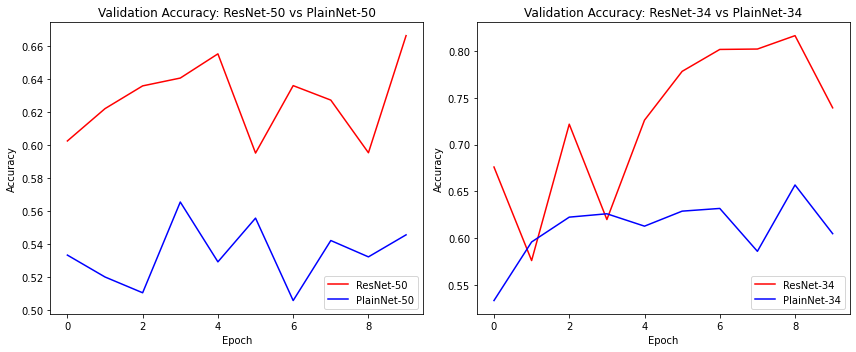

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# ResNet-50 vs PlainNet-50 비교 (validation accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['val_accuracy'], 'r', label='ResNet-50')
plt.plot(history_plain50.history['val_accuracy'], 'b', label='PlainNet-50')
plt.title('Validation Accuracy: ResNet-50 vs PlainNet-50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# ResNet-34 vs PlainNet-34 비교 (validation accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_resnet34.history['val_accuracy'], 'r', label='ResNet-34')
plt.plot(history_plain34.history['val_accuracy'], 'b', label='PlainNet-34')
plt.title('Validation Accuracy: ResNet-34 vs PlainNet-34')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


# 회고록

 Ablation Study 에 대해서 알게 되었고 이를 적용하여 비교하는 법을 배웠다. ResNet에 대해서 알게 되었고 잔차에 대해서 좀 더 세부적으로 적용하며 알 게 되었습니다.
 
 조심할 점 : 이번 경우 학습이 좀 오래걸렸는데 어디 다녀오고 하면 커널이 죽어버려서 코드를 추가하기가 어려웠다.(restart를 하면 시간이 너무 걸려서 무서웠다.
 
 아쉬운 점 : 코드 자체를 작성하는 것은 크게 어렵지 않았으나 ResNet과 이론적인 부분에서 아직 제대로 다 채우지는 못한 것 같다. 앞으로는 프로젝트를 빠르게 끝내고 남은 시간을 이론 공부에 좀 더 신경쓰고 싶다.